In [1]:
import sys
sys.path.insert(0, "..")

from src.commons.dataset import TinyImageNetDataset
from src.commons.constants import DATA_PATH, DIR_SEP
from src.commons.modded_recorder import Recorder

import logging, os

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import vit_pytorch as vit
from tqdm import tqdm

In [2]:
logging.getLogger().setLevel(logging.INFO)

In [3]:
# Load model
# https://github.com/lucidrains/vit-pytorch#parameters


# Define training parameters
BATCH_SIZE = 32
LEARNING_RATE = 5e-5
NUM_EPOCHS = 50
CHECKPOINT_PATH = ".." + DIR_SEP + os.path.join("results")
print("CHECKPOINT PATH: ", CHECKPOINT_PATH)

# Instantiate model, optimizer and loss function
model = vit.SimpleViT(
    image_size = 64,
    patch_size = 4,
    num_classes = 200,
    dim = 256,
    depth = 2,
    heads = 8,
    mlp_dim = 512
)

print(f"Total parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad) :.2e}")

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()

# Instantiate dataset
transf = transforms.Lambda(lambda T: T.long()/255)
dataset = TinyImageNetDataset(".." + DIR_SEP + DATA_PATH, transforms=transf)
print(f"Dataset size: {len(dataset)}")

# Split dataset in train/test/validation sets

train_data, test_data, val_data = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])

# Create dataloaders

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

# Attempt training on GPU
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
# elif torch.backends.mps.is_available():
#     DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')
print('DEVICE:', DEVICE)

# Send to device
model = model.to(DEVICE)
print(torch.cuda.memory_summary())

CHECKPOINT PATH:  ..\results
Total parameters: 1.64e+06
Dataset size: 100000
DEVICE: cuda
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    6410 KB |    6410 KB |    6410 KB |       0 B  |
|       from large pool |    3072 KB |    3072 KB |    3072 KB |       0 B  |
|       from small pool |    3338 KB |    3338 KB |    3338 KB |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |    6410 KB |    6410 KB | 

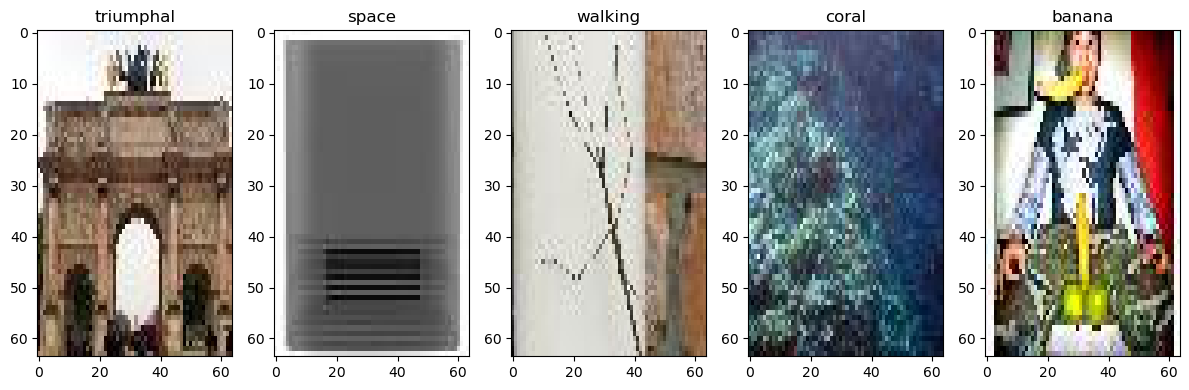

In [5]:
# Check data format

temp_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

sample = next(iter(temp_loader))
img, img_label = sample["inputs"], sample["targets"]

fig, ax = plt.subplots(1, 5, figsize=(12, 4))
for i in range(5):
    img_perm = torch.permute(img[i], (1, 2, 0)).numpy()
    ax[i].imshow(img_perm, aspect="auto")
    title = dataset.index_to_name[img_label[i].item()]
    title = title.split()
    ax[i].set_title(title[0] if isinstance(title, list) else title)
fig.tight_layout()

In [4]:
def evaluate(model, data_loader, **kwargs):
    loss_fn = kwargs.get("loss_fn", nn.CrossEntropyLoss())
    device = kwargs.get("device", torch.device("cpu"))
    
    model.eval() # set model to evaluation mode
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    avg_loss, avg_acc = 0., 0.
    for i, batch in pbar:

        data, targets = batch["inputs"], batch["targets"]
        data, targets = data.to(device), targets.to(device)
        
        model.zero_grad() # initialize gradients to zero
        with torch.no_grad(): # no need to compute gradients
            logits = model(data)
            preds = nn.functional.softmax(logits, dim=1)
            pred_cats = preds.argmax(dim=1)
            acc = (pred_cats == targets).float().mean()
           
        loss = loss_fn(logits, targets)
        avg_loss += loss.item()
        avg_acc += acc.item()
        pbar.set_description(f"loss = {loss:.3f} | acc = {acc:.3f}")
    avg_loss /= len(data_loader)
    avg_acc /= len(data_loader)
    return avg_loss, avg_acc

def fit(model, train_loader, val_loader, optimizer, **kwargs):
    loss_fn = kwargs.get("loss_fn", nn.CrossEntropyLoss())
    device = kwargs.get("device", torch.device("cpu"))
    num_epochs = kwargs.get("num_epochs", 100)

    train_loss_hist, val_loss_hist = [], []
    train_acc_hist, val_acc_hist = [], []


    for epoch in range(num_epochs):
        # Checkpoint if validation loss improves  
        if epoch > 2 and val_loss_hist[-2] > val_loss_hist[-1]:
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': val_loss_hist[-1],
                    }, os.path.join(CHECKPOINT_PATH, "simple_vit.pt"))

        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        model.train() # set model to training mode
        train_loss, train_acc = 0., 0.
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, batch in pbar:
            
            data, targets = batch["inputs"], batch["targets"]
            data, targets = data.to(device), targets.to(device)
    
            logging.debug(f"Batch - Input: {data.shape, type(data)} Target: {targets.shape, type(targets)}")

            model.zero_grad() # initialize gradients to zero
            logits = model(data) # forward pass

            logging.debug(f"Logits - {logits.shape}, {type(logits)}")

            loss = loss_fn(logits, targets) # loss computation
            loss.backward() # computing gradients (backward pass)
            
            optimizer.step() # updating the parameters of the model
            # accuracy computation
            with torch.no_grad():
                preds = nn.functional.softmax(logits, dim=1)
                pred_cats = preds.argmax(dim=1)
                acc = (pred_cats == targets).float().mean()
    
            # pop computational graph
            train_loss += loss.item()
            train_acc += acc.item() 
            pbar.set_description(f"loss = {loss:.3f} | acc = {acc:.3f}")
        

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        print(f"Train loss: {train_loss:.3f} | train acc = {train_acc:.3f}")
        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_acc) 
        
        val_loss, val_acc = evaluate(model, val_loader, loss_fn=loss_fn, device=device)
        print(f"Validation loss: {val_loss:.3f} | val acc = {val_acc:.3f}")
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_acc)
        
    return train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist

In [5]:
# Training
train_loss, val_loss, train_acc, val_acc = fit(model, train_loader, valid_loader, optimizer, num_epochs=NUM_EPOCHS, device=DEVICE)


Epoch 1/50


loss = 5.203 | acc = 0.000: 100%|██████████| 2500/2500 [03:16<00:00, 12.74it/s]


Train loss: 4.980 | train acc = 0.034


loss = 4.826 | acc = 0.062: 100%|██████████| 313/313 [00:13<00:00, 23.55it/s]


Validation loss: 4.648 | val acc = 0.066

Epoch 2/50


loss = 4.096 | acc = 0.219: 100%|██████████| 2500/2500 [03:07<00:00, 13.31it/s]


Train loss: 4.445 | train acc = 0.095


loss = 4.643 | acc = 0.062: 100%|██████████| 313/313 [00:13<00:00, 23.46it/s]


Validation loss: 4.285 | val acc = 0.120

Epoch 3/50


loss = 4.240 | acc = 0.188: 100%|██████████| 2500/2500 [03:00<00:00, 13.84it/s]


Train loss: 4.127 | train acc = 0.140


loss = 4.508 | acc = 0.062: 100%|██████████| 313/313 [00:10<00:00, 28.65it/s]


Validation loss: 4.044 | val acc = 0.150

Epoch 4/50


loss = 3.786 | acc = 0.156: 100%|██████████| 2500/2500 [02:54<00:00, 14.30it/s]


Train loss: 3.902 | train acc = 0.171


loss = 4.449 | acc = 0.125: 100%|██████████| 313/313 [00:10<00:00, 28.63it/s]


Validation loss: 3.874 | val acc = 0.177

Epoch 5/50


loss = 3.547 | acc = 0.219: 100%|██████████| 2500/2500 [5:00:41<00:00,  7.22s/it]     


Train loss: 3.734 | train acc = 0.194


loss = 4.423 | acc = 0.062: 100%|██████████| 313/313 [00:15<00:00, 20.04it/s]


Validation loss: 3.760 | val acc = 0.192

Epoch 6/50


loss = 3.998 | acc = 0.125: 100%|██████████| 2500/2500 [03:16<00:00, 12.74it/s]


Train loss: 3.597 | train acc = 0.215


loss = 4.406 | acc = 0.062: 100%|██████████| 313/313 [00:13<00:00, 22.85it/s]


Validation loss: 3.665 | val acc = 0.208

Epoch 7/50


loss = 3.475 | acc = 0.250: 100%|██████████| 2500/2500 [03:11<00:00, 13.08it/s]


Train loss: 3.474 | train acc = 0.234


loss = 4.488 | acc = 0.062: 100%|██████████| 313/313 [00:13<00:00, 23.07it/s]


Validation loss: 3.587 | val acc = 0.219

Epoch 8/50


loss = 3.837 | acc = 0.031: 100%|██████████| 2500/2500 [03:09<00:00, 13.18it/s]


Train loss: 3.359 | train acc = 0.252


loss = 4.419 | acc = 0.062: 100%|██████████| 313/313 [00:13<00:00, 23.03it/s]


Validation loss: 3.523 | val acc = 0.233

Epoch 9/50


loss = 2.882 | acc = 0.344: 100%|██████████| 2500/2500 [02:58<00:00, 14.02it/s]


Train loss: 3.254 | train acc = 0.269


loss = 4.406 | acc = 0.000: 100%|██████████| 313/313 [00:10<00:00, 29.66it/s]


Validation loss: 3.467 | val acc = 0.236

Epoch 10/50


loss = 3.325 | acc = 0.281: 100%|██████████| 2500/2500 [22:26<00:00,  1.86it/s]    


Train loss: 3.154 | train acc = 0.285


loss = 4.571 | acc = 0.062: 100%|██████████| 313/313 [00:12<00:00, 24.67it/s]


Validation loss: 3.444 | val acc = 0.241

Epoch 11/50


loss = 2.935 | acc = 0.281: 100%|██████████| 2500/2500 [03:19<00:00, 12.51it/s]


Train loss: 3.058 | train acc = 0.303


loss = 4.556 | acc = 0.125: 100%|██████████| 313/313 [00:12<00:00, 24.17it/s]


Validation loss: 3.384 | val acc = 0.252

Epoch 12/50


loss = 2.923 | acc = 0.219: 100%|██████████| 2500/2500 [03:22<00:00, 12.34it/s]


Train loss: 2.965 | train acc = 0.319


loss = 4.470 | acc = 0.188: 100%|██████████| 313/313 [00:16<00:00, 19.53it/s]


Validation loss: 3.354 | val acc = 0.260

Epoch 13/50


loss = 3.402 | acc = 0.250: 100%|██████████| 2500/2500 [03:11<00:00, 13.08it/s]


Train loss: 2.875 | train acc = 0.335


loss = 4.525 | acc = 0.062: 100%|██████████| 313/313 [00:12<00:00, 25.60it/s]


Validation loss: 3.352 | val acc = 0.259

Epoch 14/50


loss = 2.730 | acc = 0.312: 100%|██████████| 2500/2500 [02:57<00:00, 14.06it/s]


Train loss: 2.785 | train acc = 0.351


loss = 4.479 | acc = 0.062: 100%|██████████| 313/313 [00:10<00:00, 28.54it/s]


Validation loss: 3.344 | val acc = 0.257

Epoch 15/50


loss = 2.649 | acc = 0.375: 100%|██████████| 2500/2500 [03:03<00:00, 13.61it/s]


Train loss: 2.698 | train acc = 0.367


loss = 4.440 | acc = 0.188: 100%|██████████| 313/313 [00:11<00:00, 28.42it/s]


Validation loss: 3.339 | val acc = 0.263

Epoch 16/50


loss = 2.109 | acc = 0.438: 100%|██████████| 2500/2500 [02:54<00:00, 14.31it/s]


Train loss: 2.610 | train acc = 0.383


loss = 4.503 | acc = 0.125: 100%|██████████| 313/313 [00:11<00:00, 28.44it/s]


Validation loss: 3.329 | val acc = 0.262

Epoch 17/50


loss = 2.959 | acc = 0.312: 100%|██████████| 2500/2500 [02:54<00:00, 14.31it/s]


Train loss: 2.524 | train acc = 0.400


loss = 4.451 | acc = 0.062: 100%|██████████| 313/313 [00:10<00:00, 28.48it/s]


Validation loss: 3.337 | val acc = 0.267

Epoch 18/50


loss = 3.050 | acc = 0.312: 100%|██████████| 2500/2500 [02:56<00:00, 14.16it/s]


Train loss: 2.437 | train acc = 0.415


loss = 4.613 | acc = 0.062: 100%|██████████| 313/313 [00:11<00:00, 27.45it/s]


Validation loss: 3.359 | val acc = 0.268

Epoch 19/50


loss = 2.384 | acc = 0.438: 100%|██████████| 2500/2500 [02:56<00:00, 14.14it/s]


Train loss: 2.352 | train acc = 0.434


loss = 5.109 | acc = 0.062: 100%|██████████| 313/313 [00:10<00:00, 28.50it/s]


Validation loss: 3.368 | val acc = 0.266

Epoch 20/50


loss = 2.039 | acc = 0.594: 100%|██████████| 2500/2500 [02:54<00:00, 14.30it/s]


Train loss: 2.264 | train acc = 0.451


loss = 4.969 | acc = 0.125: 100%|██████████| 313/313 [00:10<00:00, 28.57it/s]


Validation loss: 3.390 | val acc = 0.262

Epoch 21/50


loss = 2.301 | acc = 0.375: 100%|██████████| 2500/2500 [02:54<00:00, 14.32it/s]


Train loss: 2.175 | train acc = 0.471


loss = 5.032 | acc = 0.125: 100%|██████████| 313/313 [00:10<00:00, 28.58it/s]


Validation loss: 3.408 | val acc = 0.263

Epoch 22/50


loss = 2.315 | acc = 0.406: 100%|██████████| 2500/2500 [02:54<00:00, 14.31it/s]


Train loss: 2.086 | train acc = 0.487


loss = 5.108 | acc = 0.125: 100%|██████████| 313/313 [00:10<00:00, 28.57it/s]


Validation loss: 3.446 | val acc = 0.261

Epoch 23/50


loss = 1.742 | acc = 0.656: 100%|██████████| 2500/2500 [02:54<00:00, 14.32it/s]


Train loss: 1.996 | train acc = 0.510


loss = 5.051 | acc = 0.125: 100%|██████████| 313/313 [00:10<00:00, 28.61it/s]


Validation loss: 3.480 | val acc = 0.258

Epoch 24/50


loss = 1.885 | acc = 0.562: 100%|██████████| 2500/2500 [02:54<00:00, 14.32it/s]


Train loss: 1.905 | train acc = 0.528


loss = 5.224 | acc = 0.125: 100%|██████████| 313/313 [00:10<00:00, 28.59it/s]


Validation loss: 3.536 | val acc = 0.254

Epoch 25/50


loss = 1.923 | acc = 0.469: 100%|██████████| 2500/2500 [02:54<00:00, 14.33it/s]


Train loss: 1.815 | train acc = 0.548


loss = 5.570 | acc = 0.062: 100%|██████████| 313/313 [00:10<00:00, 28.53it/s]


Validation loss: 3.583 | val acc = 0.255

Epoch 26/50


loss = 2.068 | acc = 0.531: 100%|██████████| 2500/2500 [02:54<00:00, 14.32it/s]


Train loss: 1.721 | train acc = 0.570


loss = 5.047 | acc = 0.188: 100%|██████████| 313/313 [00:10<00:00, 28.48it/s]


Validation loss: 3.634 | val acc = 0.253

Epoch 27/50


loss = 1.896 | acc = 0.531: 100%|██████████| 2500/2500 [02:54<00:00, 14.32it/s]


Train loss: 1.633 | train acc = 0.591


loss = 5.796 | acc = 0.062: 100%|██████████| 313/313 [00:10<00:00, 28.59it/s]


Validation loss: 3.693 | val acc = 0.252

Epoch 28/50


loss = 1.893 | acc = 0.562: 100%|██████████| 2500/2500 [02:54<00:00, 14.33it/s]


Train loss: 1.537 | train acc = 0.611


loss = 5.954 | acc = 0.125: 100%|██████████| 313/313 [00:10<00:00, 28.62it/s]


Validation loss: 3.776 | val acc = 0.244

Epoch 29/50


loss = 1.487 | acc = 0.500: 100%|██████████| 2500/2500 [03:01<00:00, 13.80it/s]


Train loss: 1.447 | train acc = 0.635


loss = 5.637 | acc = 0.125: 100%|██████████| 313/313 [00:13<00:00, 23.47it/s]


Validation loss: 3.853 | val acc = 0.241

Epoch 30/50


loss = 1.641 | acc = 0.594: 100%|██████████| 2500/2500 [03:06<00:00, 13.43it/s]


Train loss: 1.357 | train acc = 0.657


loss = 6.120 | acc = 0.125: 100%|██████████| 313/313 [00:10<00:00, 28.52it/s]


Validation loss: 3.890 | val acc = 0.241

Epoch 31/50


loss = 1.649 | acc = 0.625: 100%|██████████| 2500/2500 [02:54<00:00, 14.34it/s]


Train loss: 1.265 | train acc = 0.680


loss = 6.367 | acc = 0.125: 100%|██████████| 313/313 [00:10<00:00, 28.66it/s]


Validation loss: 3.974 | val acc = 0.244

Epoch 32/50


loss = 1.418 | acc = 0.688: 100%|██████████| 2500/2500 [02:54<00:00, 14.34it/s]


Train loss: 1.176 | train acc = 0.703


loss = 6.350 | acc = 0.188: 100%|██████████| 313/313 [00:10<00:00, 28.63it/s]


Validation loss: 4.086 | val acc = 0.240

Epoch 33/50


loss = 1.353 | acc = 0.688: 100%|██████████| 2500/2500 [28:36<00:00,  1.46it/s]    


Train loss: 1.087 | train acc = 0.725


loss = 6.442 | acc = 0.125: 100%|██████████| 313/313 [00:13<00:00, 24.07it/s]


Validation loss: 4.197 | val acc = 0.231

Epoch 34/50


loss = 0.822 | acc = 0.781: 100%|██████████| 2500/2500 [03:24<00:00, 12.24it/s]


Train loss: 1.000 | train acc = 0.749


loss = 6.840 | acc = 0.062: 100%|██████████| 313/313 [00:16<00:00, 19.02it/s]


Validation loss: 4.280 | val acc = 0.228

Epoch 35/50


loss = 0.905 | acc = 0.781: 100%|██████████| 2500/2500 [03:30<00:00, 11.88it/s]


Train loss: 0.917 | train acc = 0.769


loss = 6.608 | acc = 0.188: 100%|██████████| 313/313 [00:13<00:00, 22.42it/s]


Validation loss: 4.388 | val acc = 0.228

Epoch 36/50


loss = 1.016 | acc = 0.688: 100%|██████████| 2500/2500 [03:18<00:00, 12.62it/s]


Train loss: 0.833 | train acc = 0.793


loss = 7.034 | acc = 0.062: 100%|██████████| 313/313 [00:16<00:00, 19.19it/s]


Validation loss: 4.495 | val acc = 0.227

Epoch 37/50


loss = 0.665 | acc = 0.875: 100%|██████████| 2500/2500 [03:29<00:00, 11.95it/s]


Train loss: 0.757 | train acc = 0.814


loss = 7.049 | acc = 0.062: 100%|██████████| 313/313 [00:16<00:00, 18.99it/s]


Validation loss: 4.606 | val acc = 0.228

Epoch 38/50


loss = 1.027 | acc = 0.750: 100%|██████████| 2500/2500 [03:28<00:00, 11.99it/s]


Train loss: 0.678 | train acc = 0.838


loss = 8.164 | acc = 0.125: 100%|██████████| 313/313 [00:16<00:00, 19.34it/s]


Validation loss: 4.734 | val acc = 0.222

Epoch 39/50


loss = 0.734 | acc = 0.812: 100%|██████████| 2500/2500 [03:26<00:00, 12.13it/s]


Train loss: 0.611 | train acc = 0.855


loss = 7.389 | acc = 0.250: 100%|██████████| 313/313 [00:16<00:00, 19.36it/s]


Validation loss: 4.830 | val acc = 0.224

Epoch 40/50


loss = 0.583 | acc = 0.844: 100%|██████████| 2500/2500 [03:19<00:00, 12.55it/s]


Train loss: 0.540 | train acc = 0.875


loss = 8.042 | acc = 0.062: 100%|██████████| 313/313 [00:16<00:00, 18.95it/s]


Validation loss: 4.998 | val acc = 0.210

Epoch 41/50


loss = 0.757 | acc = 0.750: 100%|██████████| 2500/2500 [03:15<00:00, 12.81it/s]


Train loss: 0.481 | train acc = 0.891


loss = 8.586 | acc = 0.062: 100%|██████████| 313/313 [00:13<00:00, 23.12it/s]


Validation loss: 5.091 | val acc = 0.220

Epoch 42/50


loss = 0.406 | acc = 0.969: 100%|██████████| 2500/2500 [03:11<00:00, 13.02it/s]


Train loss: 0.426 | train acc = 0.907


loss = 8.190 | acc = 0.125: 100%|██████████| 313/313 [00:13<00:00, 22.49it/s]


Validation loss: 5.222 | val acc = 0.214

Epoch 43/50


loss = 0.465 | acc = 0.938: 100%|██████████| 2500/2500 [03:19<00:00, 12.52it/s]


Train loss: 0.373 | train acc = 0.921


loss = 8.890 | acc = 0.062: 100%|██████████| 313/313 [00:16<00:00, 18.84it/s]


Validation loss: 5.331 | val acc = 0.216

Epoch 44/50


loss = 0.411 | acc = 0.906: 100%|██████████| 2500/2500 [03:25<00:00, 12.16it/s]


Train loss: 0.331 | train acc = 0.932


loss = 8.858 | acc = 0.062: 100%|██████████| 313/313 [00:16<00:00, 18.69it/s]


Validation loss: 5.495 | val acc = 0.216

Epoch 45/50


loss = 0.252 | acc = 0.969: 100%|██████████| 2500/2500 [03:21<00:00, 12.39it/s]


Train loss: 0.296 | train acc = 0.940


loss = 8.068 | acc = 0.125: 100%|██████████| 313/313 [00:13<00:00, 23.62it/s]


Validation loss: 5.610 | val acc = 0.210

Epoch 46/50


loss = 0.418 | acc = 0.875: 100%|██████████| 2500/2500 [03:12<00:00, 13.01it/s]


Train loss: 0.259 | train acc = 0.950


loss = 8.981 | acc = 0.062: 100%|██████████| 313/313 [00:13<00:00, 23.68it/s]


Validation loss: 5.745 | val acc = 0.206

Epoch 47/50


loss = 0.623 | acc = 0.812: 100%|██████████| 2500/2500 [03:10<00:00, 13.13it/s]


Train loss: 0.232 | train acc = 0.957


loss = 8.939 | acc = 0.062: 100%|██████████| 313/313 [00:13<00:00, 23.73it/s]


Validation loss: 5.882 | val acc = 0.205

Epoch 48/50


loss = 0.349 | acc = 0.906: 100%|██████████| 2500/2500 [03:10<00:00, 13.11it/s]


Train loss: 0.209 | train acc = 0.962


loss = 9.517 | acc = 0.125: 100%|██████████| 313/313 [00:13<00:00, 23.81it/s]


Validation loss: 5.937 | val acc = 0.211

Epoch 49/50


loss = 0.322 | acc = 0.875: 100%|██████████| 2500/2500 [03:10<00:00, 13.12it/s]


Train loss: 0.191 | train acc = 0.966


loss = 9.608 | acc = 0.062: 100%|██████████| 313/313 [00:13<00:00, 23.67it/s]


Validation loss: 6.063 | val acc = 0.206

Epoch 50/50


loss = 0.353 | acc = 0.906: 100%|██████████| 2500/2500 [03:16<00:00, 12.71it/s]


Train loss: 0.174 | train acc = 0.968


loss = 9.980 | acc = 0.062: 100%|██████████| 313/313 [00:17<00:00, 18.22it/s]

Validation loss: 6.192 | val acc = 0.207


In [6]:
# Evaluate on test set

test_loss, test_acc = evaluate(model, test_loader, loss_fn=criterion, device=DEVICE)

loss = 4.813 | acc = 0.250: 100%|██████████| 313/313 [00:14<00:00, 21.98it/s]


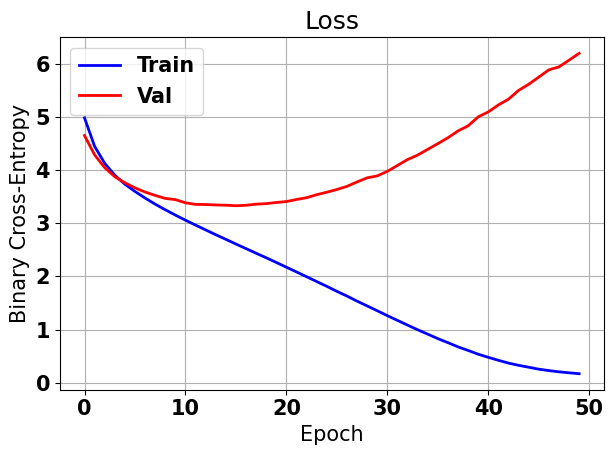

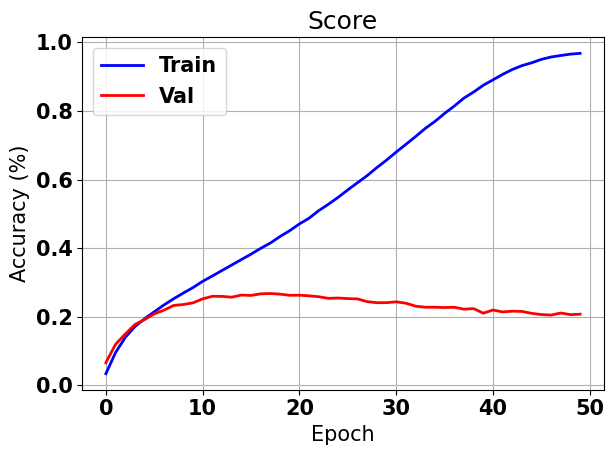

In [8]:
# Plot loss and accuracy
with plt.rc_context(rc={'font.size': 15, 'font.weight': 'bold'}):
    plt.figure()
    plt.title("Loss")
    plt.plot(train_loss, lw=2.0, c="b", label="Train")
    plt.plot(val_loss, lw=2.0, c="r", label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Binary Cross-Entropy")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    ####
    plt.figure()
    plt.title("Score")
    plt.plot(train_acc, lw=2.0, c="b", label="Train")
    plt.plot(val_acc, lw=2.0, c="r", label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

In [70]:
def predict(model, data_loader, **kwargs):
    device = kwargs.get("device", torch.device("cpu"))
    
    images, labels, results = [], [], []

    model.eval() # set model to evaluation mode
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for i, batch in pbar:

        data, targets = batch["inputs"], batch["targets"]
        data, targets = data.to(device), targets.to(device)
        
        model.zero_grad() # initialize gradients to zero
        with torch.no_grad(): # no need to compute gradients
            logits = model(data)
            preds = nn.functional.softmax(logits, dim=1)
            pred_cats = preds.argmax(dim=1)

        images.append(data)
        labels.append(targets)
        results.append(pred_cats)

    images = torch.concat(tuple([image for image in images]), dim=0)
    labels = torch.concat(tuple([label for label in labels]))
    results = torch.concat(tuple([result for result in results]))

    return images, labels, results

In [71]:
images, labels, pred_cats = predict(model, test_loader, device=DEVICE)
print(images.shape, labels.shape, pred_cats.shape)

100%|██████████| 313/313 [00:06<00:00, 47.05it/s]

torch.Size([10000, 3, 64, 64]) torch.Size([10000]) torch.Size([10000])


tensor([False, False, False,  ...,  True,  True,  True], device='cuda:0')
tensor([ True,  True,  True,  ..., False, False, False], device='cuda:0')


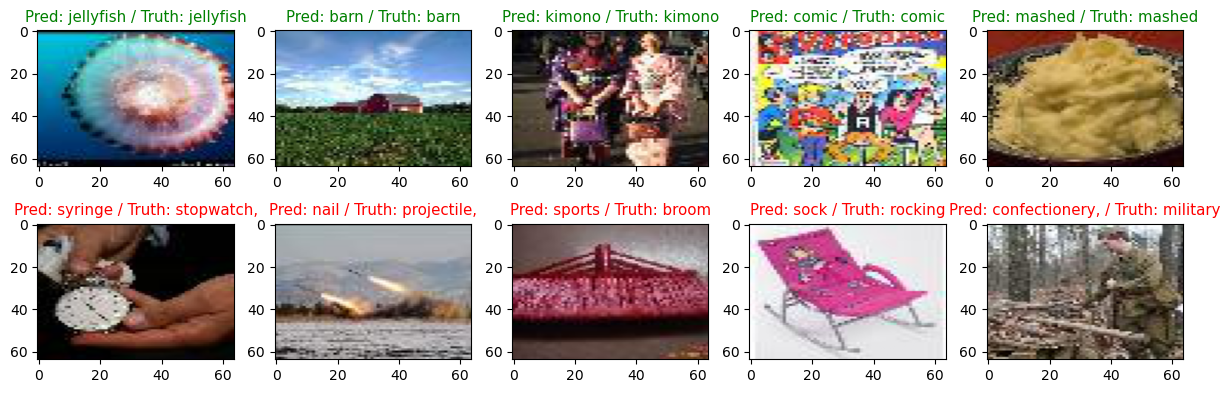

In [73]:
%matplotlib inline

corrects = torch.eq(labels, pred_cats)
wrongs = ~corrects

print(corrects)
print(wrongs)

fig, ax = plt.subplots(2, 5, figsize=(12, 4))
with plt.rc_context(rc={'font.size': 9}):
    for i in range(5): 
        # Plot correct predictions
        img = images[corrects][:5]
        img_label = labels[corrects][:5]
        pred_label = pred_cats[corrects][:5]

        img_perm = torch.permute(img[i], (1, 2, 0)).cpu().numpy()
        ax[0, i].imshow(img_perm, aspect="auto")
        
        pred_name = dataset.index_to_name[pred_label[i].item()]
        pred_name = pred_name.split()
        pred_name = pred_name[0] if isinstance(pred_name, list) else pred_name

        label_name = dataset.index_to_name[img_label[i].item()]
        label_name = label_name.split()
        label_name = label_name[0] if isinstance(label_name, list) else label_name

        ax[0, i].set_title(f"Pred: {pred_name} / Truth: {label_name}", color="green")

        # Plot wrong predictions
        img = images[wrongs][:5]
        img_label = labels[wrongs][:5]
        pred_label = pred_cats[wrongs][:5]

        img_perm = torch.permute(img[i], (1, 2, 0)).cpu().numpy()
        ax[1, i].imshow(img_perm, aspect="auto")
        
        pred_name = dataset.index_to_name[pred_label[i].item()]
        pred_name = pred_name.split()
        pred_name = pred_name[0] if isinstance(pred_name, list) else pred_name

        label_name = dataset.index_to_name[img_label[i].item()]
        label_name = label_name.split()
        label_name = label_name[0] if isinstance(label_name, list) else label_name

        ax[1, i].set_title(f"Pred: {pred_name} / Truth: {label_name}", color="red")

    fig.tight_layout()

In [4]:
# Load model
model = vit.SimpleViT(
    image_size = 64,
    patch_size = 4,
    num_classes = 200,
    dim = 256,
    depth = 2,
    heads = 8,
    mlp_dim = 512
).to("cpu")

loaded = torch.load(os.path.join(CHECKPOINT_PATH, "simple_vit_pretrained_0.pt"))
print(f"Loaded model, epoch:{loaded['epoch']}, loss:{loaded['loss']}")
model.load_state_dict(loaded["model_state_dict"])
model.eval()

Loaded model, epoch:16, loss:3.3293343412990386


SimpleViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b h w (p1 p2 c)', p1=4, p2=4)
    (1): Linear(in_features=48, out_features=256, bias=True)
  )
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Attention(
          (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (to_qkv): Linear(in_features=256, out_features=1536, bias=False)
          (to_out): Linear(in_features=512, out_features=256, bias=False)
        )
        (1): FeedForward(
          (net): Sequential(
            (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=256, out_features=512, bias=True)
            (2): GELU(approximate='none')
            (3): Linear(in_features=512, out_features=256, bias=True)
          )
        )
      )
      (1): ModuleList(
        (0): Attention(
          (norm): LayerNorm((256,), eps=1e-05, elementwise_aff

In [5]:
# Visualize attention layers
def predict_with_attention(model, data_loader, **kwargs):
    device = kwargs.get("device", torch.device("cpu"))

    images, labels, results, attn_weights = [], [], [], []

    model.eval() # set model to evaluation mode
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for i, batch in pbar:

        data, targets = batch["inputs"], batch["targets"]
        data, targets = data.to(device), targets.to(device)
        
        model.zero_grad() # initialize gradients to zero
        with torch.no_grad(): # no need to compute gradients
            logits, attns = model(data) # attns: (batch x layers x heads x patch x patch)
            preds = nn.functional.softmax(logits, dim=1)
            pred_cats = preds.argmax(dim=1)

        attns = attns.mean(dim=2) # average over heads
        attns_prod = attns[:, 0] # recursively multiply attentions
        for i in range(1, attns.shape[1]):
            attns_prod = torch.matmul(attns_prod, attns[:, i])

        images.append(data)
        labels.append(targets)
        results.append(pred_cats)
        attn_weights.append(attns_prod)

    images = torch.concat(tuple([image for image in images]), dim=0)
    labels = torch.concat(tuple([label for label in labels]))
    results = torch.concat(tuple([result for result in results]))
    attn_weights = torch.concat(tuple([attn for attn in attn_weights]))

    return images, labels, results, attn_weights

In [6]:
model = Recorder(model) # set up model to return attention weights in forward pass
images, labels, pred_cats, attns = predict_with_attention(model, test_loader, device="cpu")
model = model.eject() # remove hooks from forward pass


print(images.shape, labels.shape, pred_cats.shape, attns.shape)

  0%|          | 0/313 [00:00<?, ?it/s]

In [44]:
def find_modules(nn_module, type):
    return [module for module in nn_module.modules() if isinstance(module, type)]

find_modules(model, vit.simple_vit.Attention)

[Attention(
   (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
   (attend): Softmax(dim=-1)
   (to_qkv): Linear(in_features=256, out_features=1536, bias=False)
   (to_out): Linear(in_features=512, out_features=256, bias=False)
 ),
 Attention(
   (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
   (attend): Softmax(dim=-1)
   (to_qkv): Linear(in_features=256, out_features=1536, bias=False)
   (to_out): Linear(in_features=512, out_features=256, bias=False)
 )]

In [38]:
model

Recorder(
  (vit): SimpleViT(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b h w (p1 p2 c)', p1=4, p2=4)
      (1): Linear(in_features=48, out_features=256, bias=True)
    )
    (transformer): Transformer(
      (layers): ModuleList(
        (0): ModuleList(
          (0): Attention(
            (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (attend): Softmax(dim=-1)
            (to_qkv): Linear(in_features=256, out_features=1536, bias=False)
            (to_out): Linear(in_features=512, out_features=256, bias=False)
          )
          (1): FeedForward(
            (net): Sequential(
              (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
              (1): Linear(in_features=256, out_features=512, bias=True)
              (2): GELU(approximate='none')
              (3): Linear(in_features=512, out_features=256, bias=True)
            )
          )
        )
        (1): ModuleList(
          (0): Attent

[Attention(
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (attend): Softmax(dim=-1)
  (to_qkv): Linear(in_features=256, out_features=1536, bias=False)
  (to_out): Linear(in_features=512, out_features=256, bias=False)
), Attention(
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (attend): Softmax(dim=-1)
  (to_qkv): Linear(in_features=256, out_features=1536, bias=False)
  (to_out): Linear(in_features=512, out_features=256, bias=False)
)]


In [ ]:
%matplotlib inline

corrects = torch.eq(labels, pred_cats)
wrongs = ~corrects

print(corrects)
print(wrongs)

fig, ax = plt.subplots(2, 5, figsize=(12, 4))
with plt.rc_context(rc={'font.size': 9}):
    for i in range(5): 
        # Plot correct predictions
        img = images[corrects][:5]
        img_label = labels[corrects][:5]
        pred_label = pred_cats[corrects][:5]

        img_perm = torch.permute(img[i], (1, 2, 0)).cpu().numpy()
        ax[0, i].imshow(img_perm, aspect="auto")
        
        pred_name = dataset.index_to_name[pred_label[i].item()]
        pred_name = pred_name.split()
        pred_name = pred_name[0] if isinstance(pred_name, list) else pred_name

        label_name = dataset.index_to_name[img_label[i].item()]
        label_name = label_name.split()
        label_name = label_name[0] if isinstance(label_name, list) else label_name

        ax[0, i].set_title(f"Pred: {pred_name} / Truth: {label_name}", color="green")

        # Plot wrong predictions
        img = images[wrongs][:5]
        img_label = labels[wrongs][:5]
        pred_label = pred_cats[wrongs][:5]

        img_perm = torch.permute(img[i], (1, 2, 0)).cpu().numpy()
        ax[1, i].imshow(img_perm, aspect="auto")
        
        pred_name = dataset.index_to_name[pred_label[i].item()]
        pred_name = pred_name.split()
        pred_name = pred_name[0] if isinstance(pred_name, list) else pred_name

        label_name = dataset.index_to_name[img_label[i].item()]
        label_name = label_name.split()
        label_name = label_name[0] if isinstance(label_name, list) else label_name

        ax[1, i].set_title(f"Pred: {pred_name} / Truth: {label_name}", color="red")

    fig.tight_layout()